In [1]:
import jax.numpy as jnp
import jax.tree

from evosax.algorithms import CMA_ES

import json

import data
from nam_classic import nam_plus_hydro_api

from matplotlib import pyplot as plt

def plotlogs(logs):
    generations = [metrics["generation_counter"] for metrics in logs]
    best_fitness = [metrics["best_fitness"] for metrics in logs]

    plt.figure(figsize=(10, 5))
    plt.plot(generations, best_fitness, label="Best Fitness", marker="o", markersize=3)

    plt.title("Best fitness over generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

C:\Users\MUNRAS\PycharmProjects\NAM\.venv\Lib\site-packages\jax\_src\numpy\array_methods.py:125: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [2]:
model = nam_plus_hydro_api.NAMPlus(nam_plus_hydro_api.NAMParameters.sample(shape=(1,)),)

In [3]:
final, logs = model.optimize_cma_es(obs=data.observations_train, target=data.discharge_train, n_generations=64, n_population=1024)
plotlogs(logs)

Optimizing...:   0%|          | 0/64 [00:00<?, ?it/s]

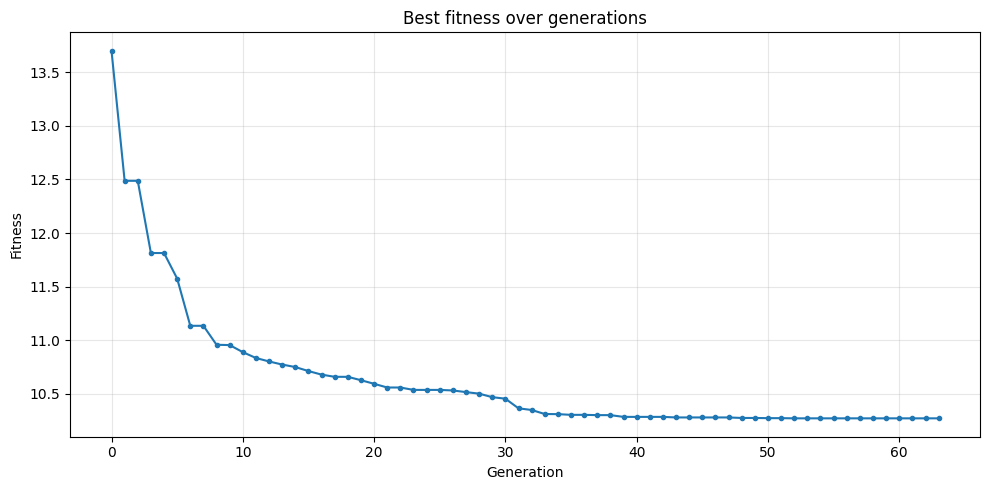

In [7]:
plotlogs(logs)

In [4]:
model_no_freeze = nam_plus_hydro_api.NAMPlus(nam_plus_hydro_api.NAMParameters.sample(shape=(1,)))
no_freeze_dict = model_no_freeze.frozen._asdict()
# for k in no_freeze_dict:
#     if k not in {"area_", "c_area_", "s_", "qr2_", "bf_"}:
#         no_freeze_dict[k] = False
for k in {"ck2_", "c_snow_"}:
    no_freeze_dict[k] = False
model_no_freeze.frozen = model_no_freeze.frozen.__class__(**no_freeze_dict)

In [5]:
final_nofreeze, logs_nofreeze = model_no_freeze.optimize_cma_es(obs=data.observations_train, target=data.discharge_train, n_generations=64, n_population=1024)
plotlogs(logs_nofreeze)

Optimizing...:   0%|          | 0/64 [00:00<?, ?it/s]

NameError: name 'plotlogs' is not defined

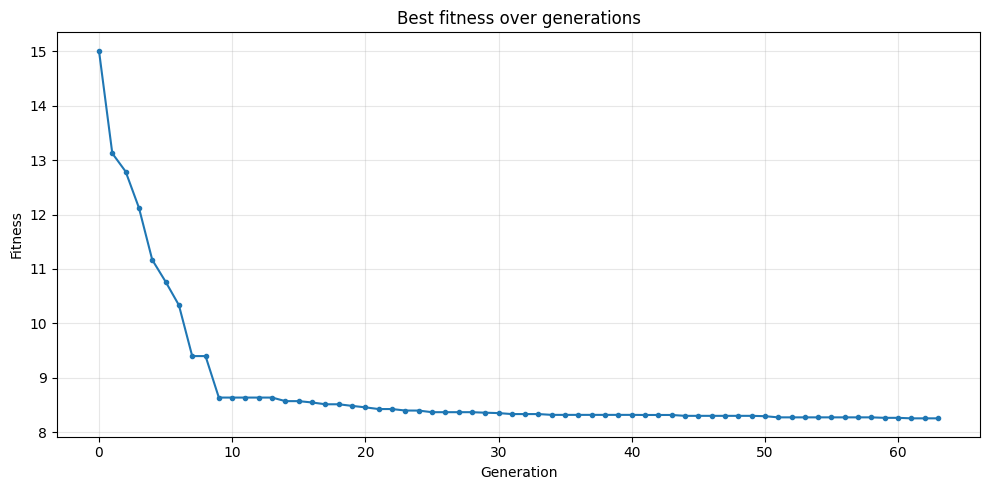

In [8]:
plotlogs(logs_nofreeze)

In [9]:
{k: (final_nofreeze._asdict()[k], final._asdict()[k]) for k in final_nofreeze._asdict()}

{'area_': (Array([1055.], dtype=float32), Array([1055.], dtype=float32)),
 'c_area_': (Array([0.37816453], dtype=float32),
  Array([0.37816453], dtype=float32)),
 'cqof_': (Array([264.5182], dtype=float32),
  Array([-487.7691], dtype=float32)),
 'ckif_': (Array([-1.0885715], dtype=float32),
  Array([-1.9421276], dtype=float32)),
 'tof_': (Array([250.20084], dtype=float32),
  Array([-132.7642], dtype=float32)),
 'tif_': (Array([-0.85807467], dtype=float32),
  Array([-0.0543281], dtype=float32)),
 'tg_': (Array([-1.9875695], dtype=float32),
  Array([0.83964765], dtype=float32)),
 'ck1_': (Array([2.1108642], dtype=float32),
  Array([1.3997391], dtype=float32)),
 'ck2_': (Array([-33.89349], dtype=float32),
  Array([-13.81551], dtype=float32)),
 'ckbf_': (Array([6.8765106], dtype=float32),
  Array([6.2079077], dtype=float32)),
 'c_snow_': (Array([26.819601], dtype=float32),
  Array([1.8545866], dtype=float32)),
 'u_max_': (Array([3.759772], dtype=float32),
  Array([3.8922684], dtype=float32

In [29]:
print(nam_plus_hydro_api.NAMPlus(final).nash_sutcliffe(data.observations_train, data.discharge_train))
print(nam_plus_hydro_api.NAMPlus(final_nofreeze).nash_sutcliffe(data.observations_train, data.discharge_train))

0.76805735
0.81365645


In [30]:
final_test, _ = nam_plus_hydro_api.NAMPlus(final).predict(data.observations_train)
final_test_nofreeze, _ = nam_plus_hydro_api.NAMPlus(final_nofreeze).predict(data.observations_train)

In [31]:
print(nam_plus_hydro_api.NAMPlus(final_test).nash_sutcliffe(data.observations_test, data.discharge_test))
print(nam_plus_hydro_api.NAMPlus(final_test_nofreeze).nash_sutcliffe(data.observations_test, data.discharge_test))

0.75616527
0.7668521


In [32]:
with open("best_namplus.json", "w") as f:
    json.dump({k:float(x[0]) for k,x in final._asdict().items()}, f)

In [2]:
with open("best_namplus.json", "r") as f:
    best_params = nam_plus_hydro_api.NAMParameters(**json.load(f))
best_model = nam_plus_hydro_api.NAMPlus(best_params)

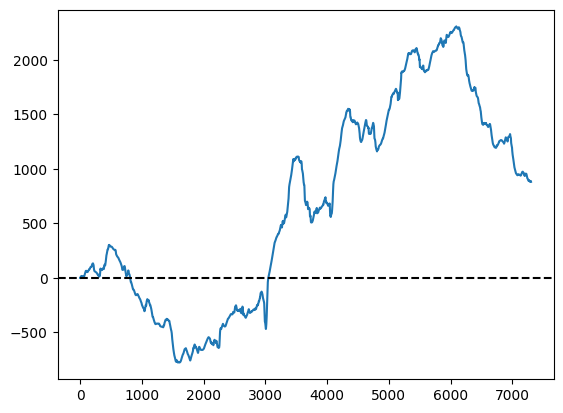

In [7]:
plt.plot(best_model.cumulative_waterbalance(data.observations_train, data.discharge_train, relative=False))
plt.axhline(y=0, linestyle="--", color="k")

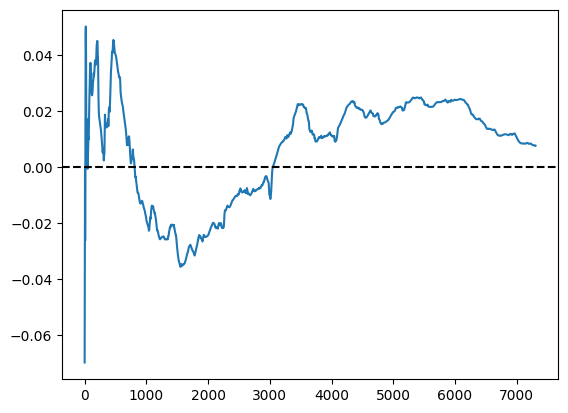

In [6]:
plt.plot(best_model.cumulative_waterbalance(data.observations_train, data.discharge_train))
plt.axhline(y=0, linestyle="--", color="k")

In [39]:
_, qpred = best_model.predict(data.observations_train)

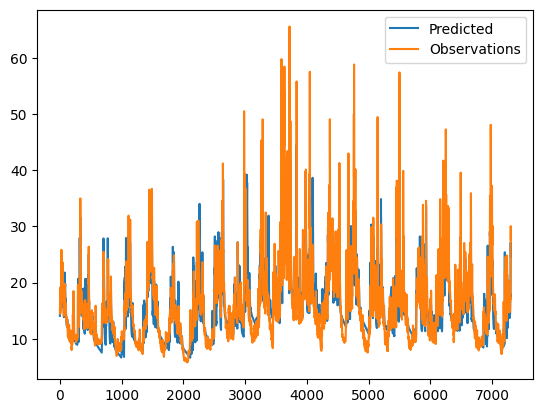

In [40]:
fig, ax = plt.subplots()
ax.plot(qpred, label="Predicted")
ax.plot(data.discharge_train.reshape(-1), label="Observations")
ax.legend()